## Superstore Challenge

The superstore dataset is a collection of ~10,000 anonymized transactions from an e-commerce store that occurred between the years 2014 and 2017.  

Your task here is to make a 'meta' dataset that aggregates information about what individual customers have done over their lifetime of interactions with the store.  

When you're done you'll have a list of each unique customer in the store (going by their name), with information like their lifetime customer value, number of orders, and their ordering behavior measured over different lags of time.  

This will be a helpful exercise to re-inforce some of the concepts discussed from class 6, like grouping and date offsets.

In [6]:
import pandas as pd
import numpy as np

ss = pd.read_excel('/Users/swllms/DAT-10-14-SW/class material/Unit2/data/superstore.xls', index_col='Date', parse_dates=['Date'])

**Column 1:** Create a column that lists every customers lifetime customer value.

In [8]:
#cust_life = 1/cr ###Customer Lifetime = 1/Churn Rate

In [9]:
total_cust = ss['Customer ID'].nunique()
total_orders = ss.groupby('Customer Name')['Order ID'].nunique()
pur_freq = total_orders / total_cust ###Purchase Frequency =  Total Number of Orders / Total Number of Customers
total_rev = ss['Sales'].sum()
avo = total_rev/total_orders ###Average Order Value = Total Revenue / Total Number of Orders
prof_mar = ss['Profit'].sum()
cust_val = avo/pur_freq ###Customer Value = Average Order Value * Purchase Frequency
rr = (total_orders > 1) / total_orders ### number of orders > 1/ number of orders = repeat rate
cr = 1-rr ###Churn Rate = 1-Repeat Rate
###CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin
cltv = ((avo * pur_freq)/cr) * prof_mar
cltv.head()

Customer Name
Aaron Bergman      1.244473e+09
Aaron Hawkins      9.679236e+08
Aaron Smayling     9.679236e+08
Adam Bellavance    9.481700e+08
Adam Hart          9.218320e+08
Name: Order ID, dtype: float64

In [11]:
clv = ss.groupby('Customer Name')['Sales'].sum().to_frame()
##cust_life_val = cust_life_val.to_frame().rename({'Sales': 'CLV'}, axis=1)
###sales = ss.merge(cust_life_val, on='Customer Name', how='left')
clv.head()

Sales
Customer Name            
Aaron Bergman     886.156
Aaron Hawkins    1744.700
Aaron Smayling   3050.692
Adam Bellavance  7755.620
Adam Hart        3250.337

**Column 2:** Create a column that lists the length of time each customer has been with the store.  This is defined as the number of days between when they made their first purchase and today.

In [455]:
### Merged it to the main colm
#first_ord = ss.groupby('Customer Name')['Order Date'].min()
#cust_duration = np.datetime64('now') - first_ord
#cust_duration = cust_duration.to_frame().rename({'Order Date': 'Customer Duration'}, axis=1)
#ss = ss.merge(cust_duration, on='Customer Name', how='left')
#ss.head()

In [12]:
# length of time customer has been with us
first_ord = ss.groupby(['Customer Name'])['Order Date'].min()
lot = np.datetime64('now') - first_ord
clv = clv.merge(lot.to_frame(), on='Customer Name')
clv.rename({'Order Date': 'Customer Duration'}, axis=1, inplace=True)
clv.head()

Sales  Customer Duration
Customer Name                               
Aaron Bergman     886.156 2094 days 15:20:59
Aaron Hawkins    1744.700 2031 days 15:20:59
Aaron Smayling   3050.692 1935 days 15:20:59
Adam Bellavance  7755.620 1517 days 15:20:59
Adam Hart        3250.337 1823 days 15:20:59

**Column 3:** Create a column that lists the total number of purchases for each customer.

In [457]:
###Merged to main dataframe
#cust_tot_pur = ss.groupby('Customer ID')['Order ID'].nunique(sum)
#cust_tot_pur = cust_tot_pur.to_frame().rename({'Order ID': 'All Orders'}, axis=1)
#ss = ss.merge(cust_tot_pur, on='Customer ID', how='left')

In [13]:
cust_tot_pur = ss.groupby('Customer Name')['Order ID'].nunique(sum)
clv = clv.merge(cust_tot_pur.to_frame(), on='Customer Name')
clv.rename({'Order ID': 'Total Purchases'}, axis=1, inplace=True)
clv.head()

Sales  Customer Duration  Total Purchases
Customer Name                                                
Aaron Bergman     886.156 2094 days 15:20:59                3
Aaron Hawkins    1744.700 2031 days 15:20:59                7
Aaron Smayling   3050.692 1935 days 15:20:59                7
Adam Bellavance  7755.620 1517 days 15:20:59                8
Adam Hart        3250.337 1823 days 15:20:59               10

**Column 4:** Create a column that assigns customers to a cohort.  

A customers cohort is determined by when they made their first purchase, and every year in your dataset has two cohorts:  the first half of the year and the second half.  

For example, if someone made their first purchase in March of 2017, their cohort would be 2017-1, or something similar.  Someone who purchased in September of 2017 would be 2017-2, and so on.

In [14]:
#first_ord = ss.groupby('Customer Name')['Order Date'].min()

date_range =[
    first_ord.between('01/01/2014', '06/30/2014'),
    first_ord.between('07/01/2014', '12/31/2014'),
    first_ord.between('01/01/2015', '06/30/2015'),
    first_ord.between('07/01/2015', '12/31/2015'),    
    first_ord.between('01/01/2016', '06/30/2016'),
    first_ord.between('07/01/2016', '12/31/2016'),
    first_ord.between('01/01/2017', '06/30/2017'),
    first_ord.between('07/01/2017', '12/31/2017')
]

group = [
    '1H-14', 
    '2H-14', 
    '1H-15', 
    '2H-15', 
    '1H-16', 
    '2H-16', 
    '1H-17', 
    '2H-17'
]
clv['Cohort'] = np.select(date_range, group, 'Other')
clv.head()

Sales  Customer Duration  Total Purchases Cohort
Customer Name                                                       
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14

In [510]:
### Could not merge this to main df because of 'numpy.ndarray' object has no attribute 'to frame'
#cohort = cohort.to_frame().rename({'Order Date': 'Cohort'}, axis=1)
#ss = ss.merge(cohort, on='Customer Name', how='left')

**Column 5:** Create a column that lists whether or not they're a repeat customer.  This means they've made more than one order.

In [495]:
### My answer resulted in a new colm titled order id instead of repeat customer. 
#total_orders = clv.groupby('Customer Name')['Total Purchases'].nunique(sum)
#repeat_cust = total_orders > 1
#clv = clv.merge(cust_tot_pur.to_frame(), on='Customer Name')
#clv.rename({'Total Purchases': 'Repeat Customer'}, axis=1)
#clv.head()

In [15]:
clv['Repeat Customer'] = np.where(clv['Total Purchases'] > 1, True, False)
clv.head()

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                          
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14   
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14   
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15   
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14   

                 Repeat Customer  
Customer Name                     
Aaron Bergman               True  
Aaron Hawkins               True  
Aaron Smayling              True  
Adam Bellavance             True  
Adam Hart                   True

**Column 6:** We want to find out what type of customer each person is.  To do this, we want to find which value of 'Segment' occurred most frequently for every single customer.  Ie, the modal value of the 'Segment' column for each customer.

In [431]:
###merged to maine df
#seg_freq = ss.groupby('Customer Name')['Segment'].agg(pd.Series.mode)
#seg_freq = seg_freq.to_frame().rename({'Segment': 'Segment Mode'}, axis=1)
#ss = ss.merge(seg_freq, on='Customer Name', how='left')

In [16]:
seg_freq = ss.groupby('Customer Name')['Segment'].agg(pd.Series.mode)
clv = clv.merge(seg_freq.to_frame(), on='Customer Name')
clv.head()

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                          
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14   
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14   
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15   
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14   

                 Repeat Customer      Segment  
Customer Name                                  
Aaron Bergman               True     Consumer  
Aaron Hawkins               True    Corporate  
Aaron Smayling              True    Corporate  
Adam Bellavance             True  Home Office  
Adam Hart                   True    Corporate

**Column 7:** Create a column that is the date *3 months after they made their first purchase*.

In [17]:
three_mo_after = pd.DateOffset(months=3)

In [18]:
three_mon_after_1_pur = ss.groupby('Customer Name')['Order Date'].min() + three_mo_after
three_mon_after_1_pur = three_mon_after_1_pur.to_frame().rename({'Order Date': '3M After Purchase 1'}, axis=1)
clv = clv.merge(three_mon_after_1_pur, on='Customer Name')
ss = ss.merge(three_mon_after_1_pur, on='Customer Name')
clv.head(2)

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                        
Aaron Bergman   886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins  1744.700 2031 days 15:20:59                7  1H-14   

               Repeat Customer    Segment 3M After Purchase 1  
Customer Name                                                  
Aaron Bergman             True   Consumer          2014-05-18  
Aaron Hawkins             True  Corporate          2014-07-22

**Column 8:** Make a column that represents one year after they made their first purchase.  Add this to your initial dataframe as well.

In [19]:
one_year = pd.DateOffset(years=1)
clv['1YR After Purchase 1'] = first_ord + one_year
clv.head()

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                          
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14   
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14   
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15   
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14   

                 Repeat Customer      Segment 3M After Purchase 1  \
Customer Name                                                       
Aaron Bergman               True     Consumer          2014-05-18   
Aaron Hawkins               True    Corporate          2014-07-22   
Aaron Smayling              True    Corporate          2014-10-27   
Adam Bellavance             True  Home Office          2015-12-18   
Adam Hart                   True    Corporate          2015-02-16   

                1YR After Purchase 1  
Customer Name                         
Aaron Bergman             2015-02-18  
Aaron Hawkins             2015-04-22  
Aaron Smayling            2015-07-27  
Adam Bellavance           2016-09-18  
Adam Hart                 2015-11-16

In [20]:
ss = ss.merge(clv['1YR After Purchase 1'].to_frame(), on='Customer Name', how='left')
ss.head()

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
2    5492  CA-2017-164098 2017-01-26 2017-01-27   First Class    CG-12520   
3    6878  US-2015-123918 2015-10-15 2015-10-15      Same Day    CG-12520   
4    6879  US-2015-123918 2015-10-15 2015-10-15      Same Day    CG-12520   

  Customer Name   Segment        Country       City  ...       Product ID  \
0   Claire Gute  Consumer  United States  Henderson  ...  FUR-BO-10001798   
1   Claire Gute  Consumer  United States  Henderson  ...  FUR-CH-10000454   
2   Claire Gute  Consumer  United States    Houston  ...  OFF-ST-10000615   
3   Claire Gute  Consumer  United States     Dallas  ...  FUR-FU-10004952   
4   Claire Gute  Consumer  United States     Dallas  ...  OFF-PA-10003001   

          Category Sub-Category  \
0        Furniture    Bookcases   
1        Furniture       Chairs   
2  Office Supplies      Storage   
3        Furniture  Furnishings   
4  Office Supplies        Paper   

                                        Product Name    Sales Quantity  \
0                  Bush Somerset Collection Bookcase  261.960        2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.940        3   
2  SimpliFile Personal File, Black Granite, 15w x...   18.160        2   
3  C-Line Cubicle Keepers Polyproplyene Holder w/...  131.376        6   
4                                         Xerox 1986    5.344        1   

  Discount    Profit  3M After Purchase 1  1YR After Purchase 1  
0      0.0   41.9136           2016-01-15            2016-10-15  
1      0.0  219.5820           2016-01-15            2016-10-15  
2      0.2    1.8160           2016-01-15            2016-10-15  
3      0.6  -95.2476           2016-01-15            2016-10-15  
4      0.2    1.8704           2016-01-15            2016-10-15  

[5 rows x 23 columns]

**Column 9:** Make a column that determines whether or not a customer made a second purchase within 90 days of their first purchase.

In [21]:
first_ord = ss.groupby('Customer Name')['Order Date'].min()
first_ord = first_ord.to_frame().rename({'Order Date': 'First Order'}, axis=1)
ss = ss.merge(first_ord, on='Customer Name', how='left')

In [22]:
ss['3M Repeat'] = ss['Order Date'].between(ss['First Order'], ss['3M After Purchase 1'], inclusive=False)
tm_repeats = ss.groupby('Customer Name')['3M Repeat'].any()
clv['3M Repeat'] = tm_repeats
clv.head()

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                          
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14   
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14   
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15   
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14   

                 Repeat Customer      Segment 3M After Purchase 1  \
Customer Name                                                       
Aaron Bergman               True     Consumer          2014-05-18   
Aaron Hawkins               True    Corporate          2014-07-22   
Aaron Smayling              True    Corporate          2014-10-27   
Adam Bellavance             True  Home Office          2015-12-18   
Adam Hart                   True    Corporate          2015-02-16   

                1YR After Purchase 1  3M Repeat  
Customer Name                                    
Aaron Bergman             2015-02-18       True  
Aaron Hawkins             2015-04-22       True  
Aaron Smayling            2015-07-27      False  
Adam Bellavance           2016-09-18      False  
Adam Hart                 2015-11-16      False

**Column 10:** Make a column that counts how many items each customer made with in their first year of purchase.

In [23]:
ss['1YR Purchases'] = ss['Order Date'].between(ss['First Order'], ss['1YR After Purchase 1'])
y_1_purchases = (ss.groupby(['Customer Name', 'Order ID'])['1YR Purchases'].sum() > 0).sum(level='Customer Name').to_frame()

In [24]:
clv = clv.merge(y_1_purchases, on='Customer Name')
clv.head()

Sales  Customer Duration  Total Purchases Cohort  \
Customer Name                                                          
Aaron Bergman     886.156 2094 days 15:20:59                3  1H-14   
Aaron Hawkins    1744.700 2031 days 15:20:59                7  1H-14   
Aaron Smayling   3050.692 1935 days 15:20:59                7  2H-14   
Adam Bellavance  7755.620 1517 days 15:20:59                8  2H-15   
Adam Hart        3250.337 1823 days 15:20:59               10  2H-14   

                 Repeat Customer      Segment 3M After Purchase 1  \
Customer Name                                                       
Aaron Bergman               True     Consumer          2014-05-18   
Aaron Hawkins               True    Corporate          2014-07-22   
Aaron Smayling              True    Corporate          2014-10-27   
Adam Bellavance             True  Home Office          2015-12-18   
Adam Hart                   True    Corporate          2015-02-16   

                1YR After Purchase 1  3M Repeat  1YR Purchases  
Customer Name                                                   
Aaron Bergman             2015-02-18       True            2.0  
Aaron Hawkins             2015-04-22       True            4.0  
Aaron Smayling            2015-07-27      False            1.0  
Adam Bellavance           2016-09-18      False            4.0  
Adam Hart                 2015-11-16      False            1.0

**Column 11:** Make a column that sums up the total value of sales for each customer one year after they made their purchase.

NameError: name 'ss' is not defined

**Hint:** For some of these columns, you'll need to break them down into a few steps.  It's okay to make  helper columns on your original dataset that make it easier for you to calculate the final result.

### Questions:

Now that you've made these columns, try and answer the following questions.

**What percentage of customers make a second purchase within 3 months after their first one?  How does this differ by customer segment?**

In [26]:

clv['3M Repeat'].mean()

0.22950819672131148

In [36]:
clv.groupby('Segment')['3M Repeat'].mean()

Segment
Consumer       0.246944
Corporate      0.207627
Home Office    0.216216
Name: 3M Repeat, dtype: float64

**How Has the 3-Month Repurchasing Rate Been Changing Across Cohorts?**

In [37]:
clv.groupby('Cohort')['3M Repeat'].mean()

Cohort
1H-14    0.177936
1H-15    0.176471
1H-16    0.333333
1H-17    0.200000
2H-14    0.273885
2H-15    0.264706
2H-16    0.133333
2H-17    0.166667
Name: 3M Repeat, dtype: float64

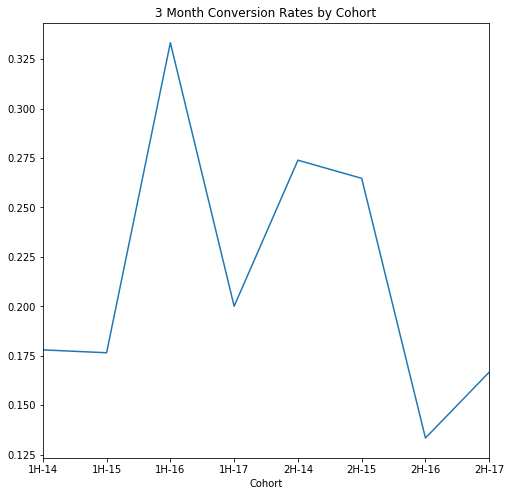

In [38]:
%matplotlib inline
cohorts = clv.groupby('Cohort')['3M Repeat'].mean().plot(figsize=(8,8), title='3 Month Conversion Rates by Cohort');

**What impact does a second order within 3 months of 1st purchase have on lifetime customer value?  Does this effect hold true for each customer segment?**

In [39]:
# looks to have a pretty big dffect
clv.groupby('3M Repeat')['Sales'].mean()

3M Repeat
False    2733.592157
True     3444.923365
Name: Sales, dtype: float64

In [40]:
# and to break it down by segment
clv.groupby(['Segment','3M Repeat'])['Sales'].mean()

Segment      3M Repeat
Consumer     False        2618.689291
             True         3513.317260
Corporate    False        2881.440142
             True         3414.633882
Home Office  False        2800.337927
             True         3275.435906
Name: Sales, dtype: float64

**What's the average expected sales value for a customer one year after their first purchase? How has this changed across cohorts?**

**How much does lifetime customer value differ across the different customer segments?**

In [35]:
clv.groupby('Segment')['Sales'].mean()

Segment
Consumer       2839.612090
Corporate      2992.145622
Home Office    2903.061814
Name: Sales, dtype: float64